In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os

In [24]:
class wifimodel():
    def __init__(self, location):
        self.train_dir = f'../../data/{location}/train/'
        self.test_dir = f'../../data/{location}/test/'
        self.model_df = pd.DataFrame()
        self.test_df = pd.DataFrame()

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0

        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])

        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../mag/{location}/magx.txt', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]

    def cal_area(self, posx, posy):
        cnt = 0
        temp = self.ref_mag_df.iloc[int(min(posx)): int(max(posx)), int(min(posy)): int(max(posy))]
        return sum(temp[temp != 0.0].count())
    
    def cal_area2(self, posx, posy):
        cnt = 0
        for i in range(len(posx)):
            if self.mag_df.iloc[posx[i], posy[i]] != 0.0:
                cnt += 1
        return cnt
    
    def define_range(self, range_num, inv_range_num):
        self.range_num = range_num
        self.inverse_range_num = inv_range_num
    
    def create_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] \
                    = 1
    
    def create_inverse_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.inverse_fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]
                
        self.Inverse_SSID_list = list(fil_model_df['SSID'].unique())
        self.Inverse_test_x_list = self.inverse_fil_test_df['x'].unique()
        self.Inverse_test_y_list = self.inverse_fil_test_df['y'].unique()
                
        self.Inverse_refwifi = np.zeros((self.maxX, self.maxY, len(self.Inverse_SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.Inverse_refwifi[int(posx)][int(posy)][self.Inverse_SSID_list.index(ssid)] \
                    = 1
    
    def create_refwifi_thres_reverse(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] <= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] <= self.rssi_thres]
        
    
        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] \
                    = 1
    def create_refwifi_thres_section(self, rssi_thres, section_len):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[(self.model_df['RSSI'] >= self.rssi_thres) & 
                                         (self.model_df['RSSI'] <= self.rssi_thres + section_len)]
        self.fil_test_df = self.test_df.loc[(self.test_df['RSSI'] >= self.rssi_thres) 
                                            & (self.test_df['RSSI'] <= self.rssi_thres + section_len)]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] \
                    = 1
    
    def test_all(self):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        fail_list = []
        
        for x in self.Inverse_test_x_list:
            for y in self.Inverse_test_y_list:
                inverse_compare_list = np.array([0 for i in range(len(self.Inverse_SSID_list))])
                
                inverse_compare_df = self.inverse_fil_test_df.loc[(self.inverse_fil_test_df["x"] == x) 
                                                                  & (self.inverse_fil_test_df["y"] == y)]
                if inverse_compare_df.empty == False:                  
                    for i in range(inverse_compare_df.shape[0]):
                        if (inverse_compare_df.iloc[i, 4] in self.Inverse_SSID_list):
                            inverse_compare_list[self.Inverse_SSID_list.index(inverse_compare_df.iloc[i, 4])] = -1
                    inverse_wifi = self.Inverse_refwifi - inverse_compare_list
                    
                    inverse_wifi = np.where(inverse_wifi == 0, 3, inverse_wifi)
                    inverse_wifi = np.where(inverse_wifi == 2, 0, inverse_wifi)
                    inverse_wifi = np.where(inverse_wifi == 1, 0, inverse_wifi)
                    
                    inverse_refwifi_sum = self.Inverse_refwifi.sum(axis=2)
                   
                    inverse_sum = inverse_wifi.sum(axis=2)
                    inverse_np = np.unique(inverse_sum.flatten())[:: -1]

                    inverse_sum = inverse_wifi.sum(axis=2)
                    inverse_np = np.unique(inverse_sum.flatten())[:: -1]

                    if len(inverse_np) <= self.inverse_range_num:
                        inverse_range_idx = len(inverse_np) - 1
                    else:
                        inverse_range_idx = self.inverse_range_num

                    if inverse_range_idx == -1:
                        inverse_rangeval = 0
                    else:
                        inverse_rangeval = np.unique(inverse_np)[:: - 1][inverse_range_idx]

                    coords = np.where((inverse_refwifi_sum!=0)
                                     & (inverse_sum >= inverse_rangeval))
                    if ((len(coords[0] != 0)) and (min(coords[0]) <= x <= max(coords[0])) and 
                        (min(coords[1]) <= y <= max(coords[1]))):
                        cnt += 1
                        coords_list.append([x, y, coords])
                        self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                                              / (self.maxX * self.maxY))
                    else:
                        fail_list.append([x, y, coords])
                    tot_cnt += 1
                    
                    if (tot_cnt % 50 == 0):
                        print(f"현재 진행 상황 : {tot_cnt} 회")
                        print(f"성공 횟수 : {cnt}회")
        

        print(f"test 횟수 : {tot_cnt}, 성공 횟수 : {cnt}")
        print(cnt * 100 / tot_cnt)
        print(np.average(self.area_list))
        
        return coords_list, cnt / tot_cnt, np.average(self.area_list), fail_list
    
    def show_area_dist(self):
        plt.hist(pd.DataFrame(self.area_list).values)
        plt.show()
    
    def test_one(self, idx):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        
        self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
        test_list = list(self.fil_test_df['x_y'].unique())[idx].split('\t')
        
        x = float(test_list[0])
        y = float(test_list[1])
        
        compare_list = np.array([0 for i in range(len(self.SSID_list))])
        compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
        
        
        if compare_df.empty == False:
            for i in range(compare_df.shape[0]):
                if (compare_df.iloc[i, 4] in self.SSID_list):
                    compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1

            temp_wifi = self.refwifi - compare_list
            temp_wifi = np.where(temp_wifi == 0, 3, temp_wifi)
            temp_wifi = np.where(temp_wifi == 2, 0, temp_wifi)
            temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
            temp_wifi = np.where(temp_wifi == 3, 1, temp_wifi)
            
            refwifi_sum = self.refwifi.sum(axis=2)
            sum_temp = temp_wifi.sum(axis=2)
            sum_np = np.unique(sum_temp.flatten())[:: -1]

            if len(sum_np) <= self.range_num:
                range_idx = len(sum_np) - 1
            else:
                range_idx = self.range_num

            if range_idx == -1:
                rangeval = 0
            else:
                rangeval = np.unique(sum_np)[:: - 1][range_idx]

            coords = np.where((sum_temp >= rangeval) & (refwifi_sum!=0))
            
            coords_list.append([x, y, coords])
            self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                      / (self.maxX * self.maxY))
        
        return coords_list, x, y,coords, sum_np
    
    def save_refwifi(self):
        file_name = f'../wifihashmap/{self.location}/wifihashmap.txt'

        path_save = open(file_name, 'w')

        for x in range(self.maxX + 1):
            for y in range(self.maxY + 1):
                if(x % 6 == 0) and (y % 6 == 0):
                    content = str(x) + "\t" + str(y) + "\t" + "".join(list(map(str, self.refwifi[x][y]))) + "\n"
                    path_save.write(content)
        path_save.close()
        
        file_name = f'../wifihashmap/{self.location}/wifilist.txt'

        path_save = open(file_name, 'w')

        content = "\t".join(self.SSID_list)
        path_save.write(content)
        path_save.close()

In [46]:
basic_thres_list = [-75]
inverse_thres_list = [-66, -69, -72, -75, -78]
basic_range = 6
inverse_range_list = [2, 4, 6, 8]

model = wifimodel('하나스퀘어')

In [47]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 97회
현재 진행 상황 : 150 회
성공 횟수 : 137회
현재 진행 상황 : 200 회
성공 횟수 : 155회
현재 진행 상황 : 250 회
성공 횟수 : 199회
현재 진행 상황 : 300 회
성공 횟수 : 245회
현재 진행 상황 : 350 회
성공 횟수 : 287회
현재 진행 상황 : 400 회
성공 횟수 : 337회
현재 진행 상황 : 450 회
성공 횟수 : 378회
현재 진행 상황 : 500 회
성공 횟수 : 426회
현재 진행 상황 : 550 회
성공 횟수 : 475회
현재 진행 상황 : 600 회
성공 횟수 : 511회
현재 진행 상황 : 650 회
성공 횟수 : 544회
test 횟수 : 683, 성공 횟수 : 555
81.25915080527086
0.4292481238852967
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 644회
test 횟수 : 683, 성공 횟수 : 677
99.12152269399706
0.7340219877859459
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 

현재 진행 상황 : 300 회
성공 횟수 : 283회
현재 진행 상황 : 350 회
성공 횟수 : 326회
현재 진행 상황 : 400 회
성공 횟수 : 376회
현재 진행 상황 : 450 회
성공 횟수 : 426회
현재 진행 상황 : 500 회
성공 횟수 : 476회
현재 진행 상황 : 550 회
성공 횟수 : 526회
현재 진행 상황 : 600 회
성공 횟수 : 576회
현재 진행 상황 : 650 회
성공 횟수 : 626회
test 횟수 : 694, 성공 횟수 : 670
96.54178674351586
0.5320308294096516
현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 97회
현재 진행 상황 : 150 회
성공 횟수 : 147회
현재 진행 상황 : 200 회
성공 횟수 : 197회
현재 진행 상황 : 250 회
성공 횟수 : 247회
현재 진행 상황 : 300 회
성공 횟수 : 297회
현재 진행 상황 : 350 회
성공 횟수 : 347회
현재 진행 상황 : 400 회
성공 횟수 : 397회
현재 진행 상황 : 450 회
성공 횟수 : 447회
현재 진행 상황 : 500 회
성공 횟수 : 497회
현재 진행 상황 : 550 회
성공 횟수 : 547회
현재 진행 상황 : 600 회
성공 횟수 : 597회
현재 진행 상황 : 650 회
성공 횟수 : 647회
test 횟수 : 694, 성공 횟수 : 691
99.56772334293949
0.6314335150567363


-66
[0.8125915080527086, 0.9912152269399708, 1.0, 1.0]
[0.4292481238852967, 0.7340219877859459, 0.926842246636324, 0.9415867480383608]


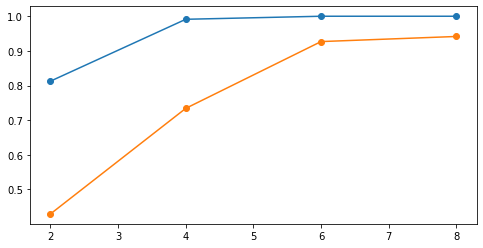

-69
[0.7053701015965167, 0.9564586357039188, 1.0, 1.0]
[0.25718806363967656, 0.45839847421502317, 0.6134118328770766, 0.8328417849288632]


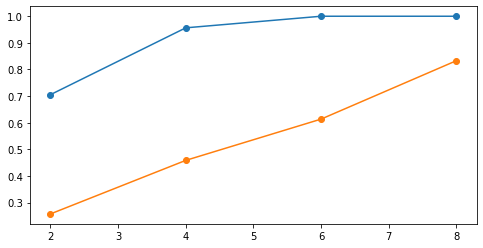

-72
[0.7492795389048992, 0.9899135446685879, 0.9956772334293948, 1.0]
[0.22312814615890383, 0.3692325182086269, 0.5835455701366463, 0.7108058767832502]


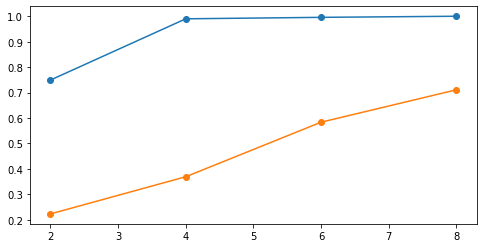

-75
[0.6138328530259366, 0.9438040345821326, 0.9956772334293948, 1.0]
[0.1921845135817643, 0.31676486423913736, 0.5028434161549568, 0.6253990867449708]


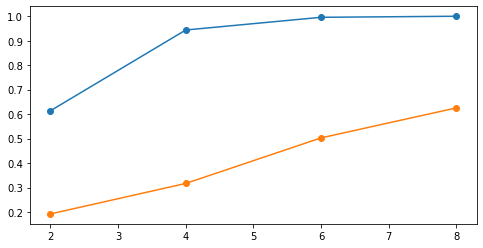

-78
[0.45244956772334294, 0.8544668587896254, 0.9654178674351584, 0.9956772334293948]
[0.16337713280101743, 0.37901821161632737, 0.5320308294096516, 0.6314335150567363]


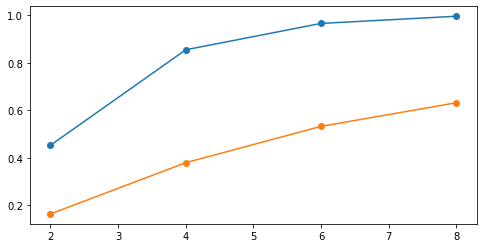

In [48]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [49]:
basic_thres_list = [-75]
inverse_thres_list = [-81, -84, -87, -90, -93]
basic_range = 6
inverse_range_list = [2, 4, 6, 8]

model = wifimodel('하나스퀘어')

In [50]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 0회
현재 진행 상황 : 100 회
성공 횟수 : 11회
현재 진행 상황 : 150 회
성공 횟수 : 39회
현재 진행 상황 : 200 회
성공 횟수 : 45회
현재 진행 상황 : 250 회
성공 횟수 : 51회
현재 진행 상황 : 300 회
성공 횟수 : 81회
현재 진행 상황 : 350 회
성공 횟수 : 95회
현재 진행 상황 : 400 회
성공 횟수 : 115회
현재 진행 상황 : 450 회
성공 횟수 : 134회
현재 진행 상황 : 500 회
성공 횟수 : 161회
현재 진행 상황 : 550 회
성공 횟수 : 171회
현재 진행 상황 : 600 회
성공 횟수 : 183회
현재 진행 상황 : 650 회
성공 횟수 : 205회
test 횟수 : 694, 성공 횟수 : 233
33.57348703170029
0.16893059495340967
현재 진행 상황 : 50 회
성공 횟수 : 1회
현재 진행 상황 : 100 회
성공 횟수 : 32회
현재 진행 상황 : 150 회
성공 횟수 : 82회
현재 진행 상황 : 200 회
성공 횟수 : 114회
현재 진행 상황 : 250 회
성공 횟수 : 151회
현재 진행 상황 : 300 회
성공 횟수 : 198회
현재 진행 상황 : 350 회
성공 횟수 : 234회
현재 진행 상황 : 400 회
성공 횟수 : 284회
현재 진행 상황 : 450 회
성공 횟수 : 332회
현재 진행 상황 : 500 회
성공 횟수 : 381회
현재 진행 상황 : 550 회
성공 횟수 : 415회
현재 진행 상황 : 600 회
성공 횟수 : 443회
현재 진행 상황 : 650 회
성공 횟수 : 477회
test 횟수 : 694, 성공 횟수 : 514
74.06340057636888
0.3080278204701334
현재 진행 상황 : 50 회
성공 횟수 : 13회
현재 진행 상황 : 100 회
성공 횟수 : 62회
현재 진행 상황 : 150 회
성공 횟수 : 112회
현재 진행 상황 : 200 회
성

현재 진행 상황 : 300 회
성공 횟수 : 207회
현재 진행 상황 : 350 회
성공 횟수 : 257회
현재 진행 상황 : 400 회
성공 횟수 : 307회
현재 진행 상황 : 450 회
성공 횟수 : 352회
현재 진행 상황 : 500 회
성공 횟수 : 397회
현재 진행 상황 : 550 회
성공 횟수 : 433회
현재 진행 상황 : 600 회
성공 횟수 : 465회
현재 진행 상황 : 650 회
성공 횟수 : 498회
test 횟수 : 694, 성공 횟수 : 542
78.09798270893371
0.2970642644989276
현재 진행 상황 : 50 회
성공 횟수 : 36회
현재 진행 상황 : 100 회
성공 횟수 : 79회
현재 진행 상황 : 150 회
성공 횟수 : 129회
현재 진행 상황 : 200 회
성공 횟수 : 179회
현재 진행 상황 : 250 회
성공 횟수 : 229회
현재 진행 상황 : 300 회
성공 횟수 : 276회
현재 진행 상황 : 350 회
성공 횟수 : 326회
현재 진행 상황 : 400 회
성공 횟수 : 376회
현재 진행 상황 : 450 회
성공 횟수 : 424회
현재 진행 상황 : 500 회
성공 횟수 : 474회
현재 진행 상황 : 550 회
성공 횟수 : 521회
현재 진행 상황 : 600 회
성공 횟수 : 558회
현재 진행 상황 : 650 회
성공 횟수 : 592회
test 횟수 : 694, 성공 횟수 : 636
91.64265129682997
0.38167161809393124


-81
[0.3357348703170029, 0.7406340057636888, 0.9365994236311239, 0.9697406340057637]
[0.16893059495340967, 0.3080278204701334, 0.4830903894669836, 0.5932878573817412]


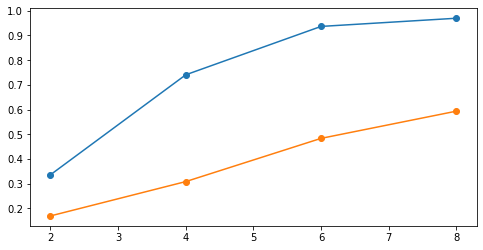

-84
[0.1988472622478386, 0.5778097982708934, 0.8285302593659942, 0.9365994236311239]
[0.11944340793944501, 0.2739851717856817, 0.43529987415437044, 0.5352305049829431]


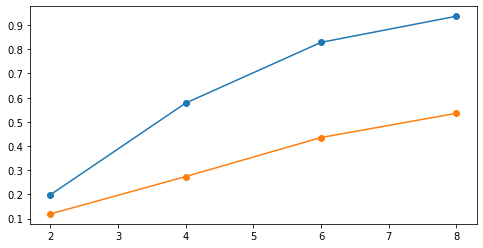

-87
[0.23487031700288186, 0.5461095100864554, 0.776657060518732, 0.8789625360230547]
[0.1681529651190778, 0.3319518564556737, 0.4365933210797488, 0.5084395790383762]


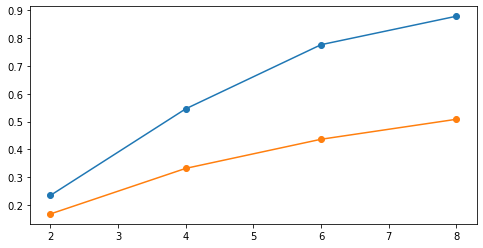

-90
[0.2838616714697406, 0.5619596541786743, 0.7550432276657061, 0.8847262247838616]
[0.20281820156154223, 0.2904547936806001, 0.35539023427789507, 0.48552442211769103]


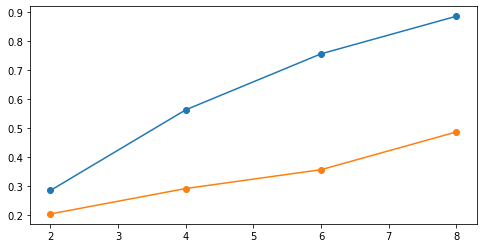

-93
[0.17002881844380405, 0.5720461095100865, 0.7809798270893372, 0.9164265129682997]
[0.13603053927541828, 0.2007613152716809, 0.2970642644989276, 0.38167161809393124]


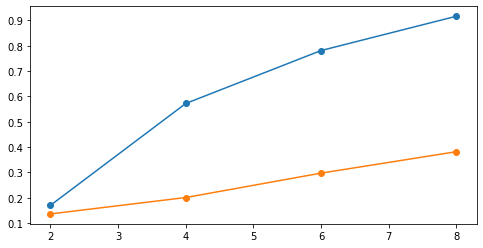

In [51]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

In [41]:
basic_thres_list = [-78]
inverse_thres_list = [-81, -84, -87, -90, -93, -96]
basic_range = 20
inverse_range_list = [1, 2, 3, 5]

model = wifimodel('포스코실험동')

In [42]:
tot_acc_list = []
tot_list_area = []
tot_area_dist = []

for inverse_thres in inverse_thres_list:
    model.create_inverse_refwifi(inverse_thres)
    acc_list = []
    list_area = []
    area_dist = []
    for inverse_range in inverse_range_list:
        model.define_range(basic_range, inverse_range)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 50 회
성공 횟수 : 47회
현재 진행 상황 : 100 회
성공 횟수 : 92회
현재 진행 상황 : 150 회
성공 횟수 : 129회
현재 진행 상황 : 200 회
성공 횟수 : 177회
현재 진행 상황 : 250 회
성공 횟수 : 220회
현재 진행 상황 : 300 회
성공 횟수 : 270회
현재 진행 상황 : 350 회
성공 횟수 : 311회
현재 진행 상황 : 400 회
성공 횟수 : 353회
현재 진행 상황 : 450 회
성공 횟수 : 396회
현재 진행 상황 : 500 회
성공 횟수 : 446회
현재 진행 상황 : 550 회
성공 횟수 : 496회
현재 진행 상황 : 600 회
성공 횟수 : 537회
현재 진행 상황 : 650 회
성공 횟수 : 555회
test 횟수 : 655, 성공 횟수 : 557
85.0381679389313
0.7815092316198413
현재 진행 상황 : 50 회
성공 횟수 : 49회
현재 진행 상황 : 100 회
성공 횟수 : 99회
현재 진행 상황 : 150 회
성공 횟수 : 149회
현재 진행 상황 : 200 회
성공 횟수 : 198회
현재 진행 상황 : 250 회
성공 횟수 : 245회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 350 회
성공 횟수 : 342회
현재 진행 상황 : 400 회
성공 횟수 : 392회
현재 진행 상황 : 450 회
성공 횟수 : 442회
현재 진행 상황 : 500 회
성공 횟수 : 492회
현재 진행 상황 : 550 회
성공 횟수 : 542회
현재 진행 상황 : 600 회
성공 횟수 : 592회
현재 진행 상황 : 650 회
성공 횟수 : 618회
test 횟수 : 655, 성공 횟수 : 621
94.80916030534351
0.8166689461420833
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 

현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 349회
현재 진행 상황 : 400 회
성공 횟수 : 396회
현재 진행 상황 : 450 회
성공 횟수 : 445회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 550 회
성공 횟수 : 541회
현재 진행 상황 : 600 회
성공 횟수 : 591회
현재 진행 상황 : 650 회
성공 횟수 : 640회
test 횟수 : 655, 성공 횟수 : 645
98.47328244274809
0.9632786560765995
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 350 회
성공 횟수 : 350회
현재 진행 상황 : 400 회
성공 횟수 : 400회
현재 진행 상황 : 450 회
성공 횟수 : 450회
현재 진행 상황 : 500 회
성공 횟수 : 500회
현재 진행 상황 : 550 회
성공 횟수 : 550회
현재 진행 상황 : 600 회
성공 횟수 : 600회
현재 진행 상황 : 650 회
성공 횟수 : 650회
test 횟수 : 655, 성공 횟수 : 655
100.0
0.9926434253085771
현재 진행 상황 : 50 회
성공 횟수 : 21회
현재 진행 상황 : 100 회
성공 횟수 : 32회
현재 진행 상황 : 150 회
성공 횟수 : 40회
현재 진행 상황 : 200 회
성공 횟수 : 70회
현재 진행 상황 : 250 회
성공 횟수 : 107회
현재 진행 상황 : 300 회
성공 횟수 : 148회
현재 진행 상황 : 350 회
성공 횟수 : 175회
현재 진행 상황 : 400 회
성공 횟

-81
[0.850381679389313, 0.9480916030534351, 0.9725190839694656, 0.9908396946564886]
[0.7815092316198413, 0.8166689461420833, 0.8954322156578354, 0.987233952171517]


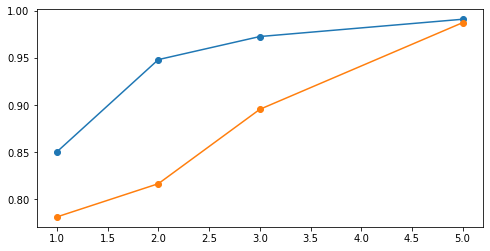

-84
[0.8549618320610687, 0.934351145038168, 0.9709923664122138, 0.9954198473282443]
[0.8634411734046271, 0.9819927087838342, 0.9919858091123369, 0.9933002919284002]


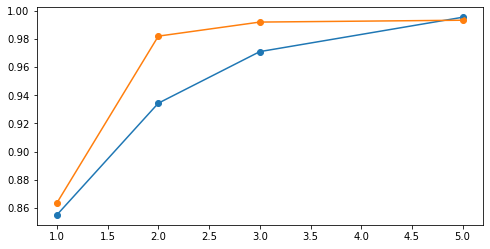

-87
[0.9038167938931297, 0.9587786259541985, 0.9954198473282443, 1.0]
[0.7968352486751319, 0.9641628986916236, 0.9880490341601861, 0.9933713921302909]


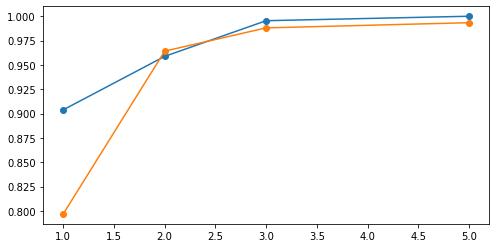

-90
[0.8244274809160306, 0.9404580152671755, 1.0, 1.0]
[0.7652524410160186, 0.9427972491082235, 0.9776729224287036, 0.9933713921302909]


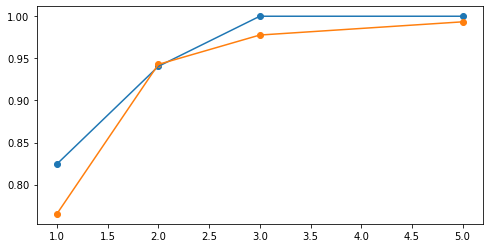

-93
[0.7007633587786259, 0.9068702290076336, 0.9847328244274809, 1.0]
[0.5864286615180162, 0.840908394099753, 0.9632786560765995, 0.9926434253085771]


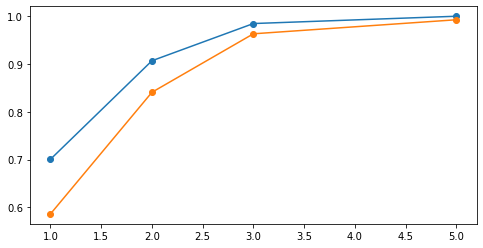

-96
[0.5435114503816794, 0.8931297709923665, 0.9786259541984733, 1.0]
[0.3937775045129914, 0.7098920640191542, 0.9174439994076238, 0.9921176714928948]


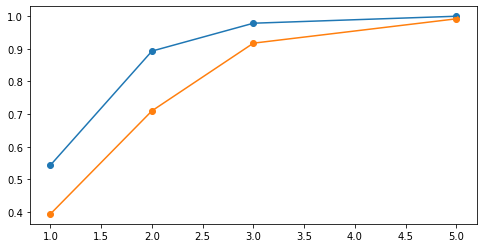

In [43]:
for i in range(len(tot_acc_list)):
    print(inverse_thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(inverse_range_list,tot_acc_list[i])
    plt.plot(inverse_range_list,tot_list_area[i])
    plt.scatter(inverse_range_list, tot_acc_list[i])
    plt.scatter(inverse_range_list, tot_list_area[i])
    plt.show()

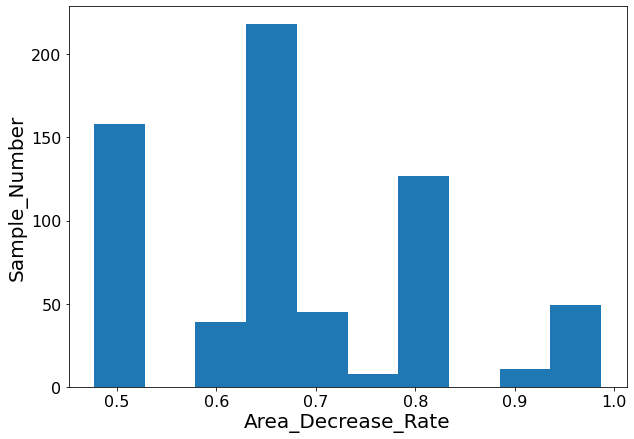

In [33]:
plt.figure(figsize = (10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('axes', labelsize=20)
plt.xlabel('Area_Decrease_Rate')
plt.ylabel('Sample_Number')
plt.hist(model.area_list)
plt.show()